##### Imports

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

##### Defining LeNet-5 Model Architecture

In [18]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size=5,stride=1,padding=2) # (28x28x1) -> (28X28x6)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2,stride=2) # (28x28x6) -> (14x14x6)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5,stride=1) # (14x14x6) -> (10x10x16) -> (5x5x16)
        self.fc1 = nn.Linear(16*5*5,120) 
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x))) # conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x))) # conv2 -> ReLU -> Pool
        x = x.view(-1,16*5*5) # Flatten
        x = self.relu(self.fc1(x)) # Fully Connected Layer1 -> ReLU
        x = self.relu(self.fc2(x)) # Fully Connected Layer2 -> ReLU
        x = self.fc3(x) # Fully Connected Layer3 (Output)
        return x



##### Hyperparameters

In [19]:
batch_size = 64
epochs = 10
learning_rate = 0.001

##### Data Loading and Transformation

In [20]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='data',train=True,transform=transform,download=True)
test_dataset = torchvision.datasets.MNIST(root='data',train=False,transform=transform,download=True)
train_loader = DataLoader(train_dataset,batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size,False)

##### Model, Loss and Optimizer

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizers = optim.Adam(model.parameters(),learning_rate)

##### Model Training & Evaluation

In [22]:
# Training Loop
train_losses,test_accuracies = [],[]
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        optimizers.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizers.step()
        running_loss+=loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Evalutation
    model.eval()
    correct,total = 0,0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            total+=labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy on test test: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.2801
Accuracy on test test: 97.12%
Epoch [2/10], Loss: 0.0747
Accuracy on test test: 98.32%
Epoch [3/10], Loss: 0.0527
Accuracy on test test: 98.65%
Epoch [4/10], Loss: 0.0422
Accuracy on test test: 98.79%
Epoch [5/10], Loss: 0.0343
Accuracy on test test: 98.80%
Epoch [6/10], Loss: 0.0276
Accuracy on test test: 98.83%
Epoch [7/10], Loss: 0.0250
Accuracy on test test: 98.95%
Epoch [8/10], Loss: 0.0214
Accuracy on test test: 99.05%
Epoch [9/10], Loss: 0.0194
Accuracy on test test: 99.00%
Epoch [10/10], Loss: 0.0161
Accuracy on test test: 99.15%


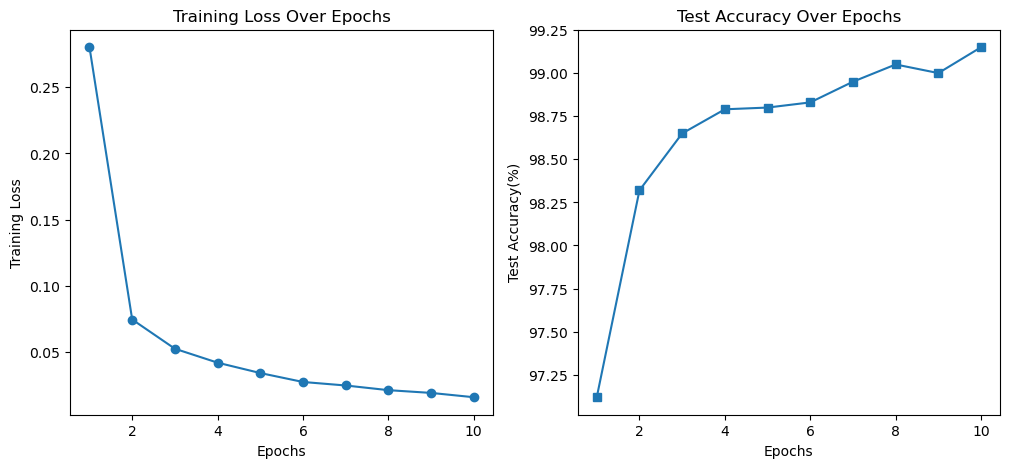

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,epochs+1),train_losses,marker='o',linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')


plt.subplot(1,2,2)
plt.plot(range(1,epochs+1),test_accuracies,marker='s',linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy(%)')
plt.title('Test Accuracy Over Epochs')
plt.show()


In [27]:
# Inference Function:
def predict_image(image):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)
        output = model(image)
        _,predicted = torch.max(output,1)
    return predicted.item()

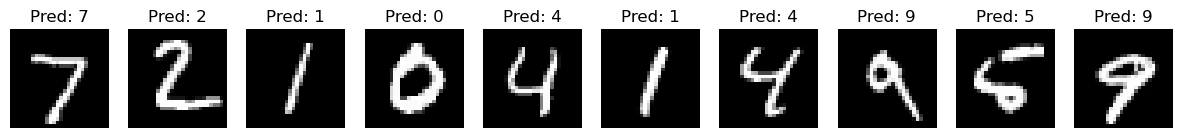

In [29]:
# Visualizaing Predictions

samples,labels = next(iter(test_loader))
samples,labels = samples.to(device),labels.to(device)
predictions = [predict_image(img) for img in samples[:10]]

fix,axes = plt.subplots(1,10,figsize=(15,4))
for i,ax in enumerate(axes):
    ax.imshow(samples[i].cpu().squeeze(),cmap='gray')
    ax.set_title(f'Pred: {predictions[i]}')
    ax.axis('off')
plt.show()